In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [1]:
import os
import sys
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential

# Disable tenforflow information messages about GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Disable tenforflow information messages 
tf.get_logger().setLevel('ERROR')
# Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)
# Set the random seed


2023-05-23 13:23:25.995241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 13:23:27.409712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-23 13:23:30.168910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 13:23:30.349996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 13:23:30.350646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

Params

In [2]:
random_seed = 42
batch_size = 16
image_size = (350, 350)
input_shape = (350, 350, 3)
color_mode = "rgb"
seed_train_validation = 42
shuffle_value = True
validation_split = 0.25

train_data_dir = "dataset/mvtec/bottle/train/"
test_data_dir = "dataset/mvtec/bottle/test/"

Load Dataset

In [3]:
# Load the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_data_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = image_size,
    validation_split = validation_split,
    subset = "training",
    seed = seed_train_validation,
    color_mode = color_mode,
    shuffle = shuffle_value
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size = image_size,
    validation_split = validation_split,
    subset = "validation",
    seed = seed_train_validation,
    color_mode = color_mode,
    shuffle = shuffle_value
    )

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_data_dir,
    labels='inferred',
    label_mode='int',
    image_size = image_size,
    seed = seed_train_validation,
    color_mode = color_mode,
    shuffle = shuffle_value
    )


Found 266 files belonging to 2 classes.
Using 200 files for training.


2023-05-23 13:23:33.031849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 13:23:33.032416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 13:23:33.032785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 13:23:34.371227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 13:23:34.372005: I tensorflow/compile

Found 266 files belonging to 2 classes.
Using 66 files for validation.
Found 6 files belonging to 2 classes.


2023-05-23 13:23:37.439187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [200]
	 [[{{node Placeholder/_4}}]]
2023-05-23 13:23:37.439489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [200]
	 [[{{node Placeholder/_4}}]]


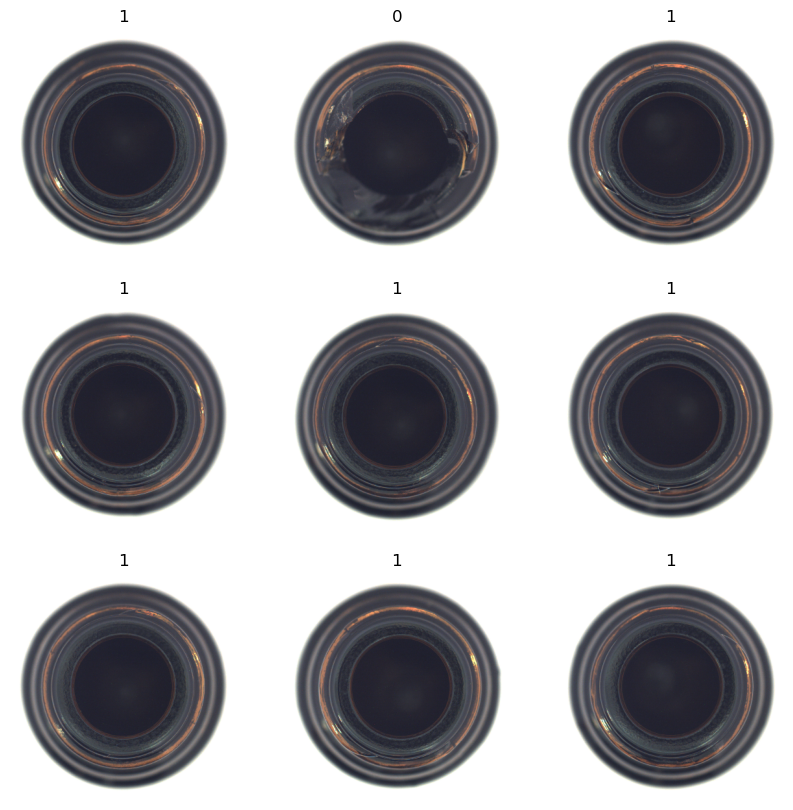

In [4]:
# plot some images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")
        

In [5]:
# Data augmentation layer 
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    ]
)


In [6]:
# Create a rescaling layer

scaling_layer = Rescaling(1.0 / 255)

# Scale the datasets
train_data_scaled = train_ds.map(lambda x, y: (scaling_layer(x), y))
test_data_scaled = test_ds.map(lambda x, y: (scaling_layer(x), y))
val_data_scaled = val_ds.map(lambda x, y: (scaling_layer(x), y))

# Test that the scaling has worked by printing the min and max value from one the images
image_batch, labels_batch = next(iter(train_data_scaled))



2023-05-23 13:23:49.517380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [200]
	 [[{{node Placeholder/_4}}]]
2023-05-23 13:23:49.517737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]


In [7]:
# Autotune the datasets
AUTOTUNE = tf.data.AUTOTUNE

train_data_scaled = train_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)
test_data_scaled = test_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)
val_data_scaled = val_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)


In [8]:
# define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=25,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_checkpoint = ModelCheckpoint(
    "models/model.{epoch:02d}-{val_loss:.2f}.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
callback_list = [early_stopping, reduce_lr, model_checkpoint]


Models 

Epoch 1/100


2023-05-23 13:23:59.229464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [200]
	 [[{{node Placeholder/_4}}]]
2023-05-23 13:23:59.229768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]
2023-05-23 13:24:02.489485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-23 13:24:03.748391: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-23 13:24:04.425317: I tensorflow/compiler/xla/se

13/13 [==============================] - ETA: 0s - loss: 0.9193 - accuracy: 0.6800

2023-05-23 13:24:07.998990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [66]
	 [[{{node Placeholder/_4}}]]
2023-05-23 13:24:07.999286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [66]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_loss improved from inf to 0.60804, saving model to models/model.01-0.61.h5
13/13 [==============================] - 10s 171ms/step - loss: 0.9193 - accuracy: 0.6800 - val_loss: 0.6080 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7750
Epoch 2: val_loss improved from 0.60804 to 0.56050, saving model to models/model.02-0.56.h5
13/13 [==============================] - 1s 78ms/step - loss: 0.5621 - accuracy: 0.7750 - val_loss: 0.5605 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5600 - accuracy: 0.7708
Epoch 3: val_loss improved from 0.56050 to 0.54251, saving model to models/model.03-0.54.h5
13/13 [==============================] - 1s 85ms/step - loss: 0.5564 - accuracy: 0.7750 - val_loss: 0.5425 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.7750
Epoch 4: va

2023-05-23 13:24:47.389224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6]
	 [[{{node Placeholder/_0}}]]
2023-05-23 13:24:47.389612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 278ms/step - loss: 0.1402 - accuracy: 0.8333
test loss, test acc: [0.14023901522159576, 0.8333333134651184]


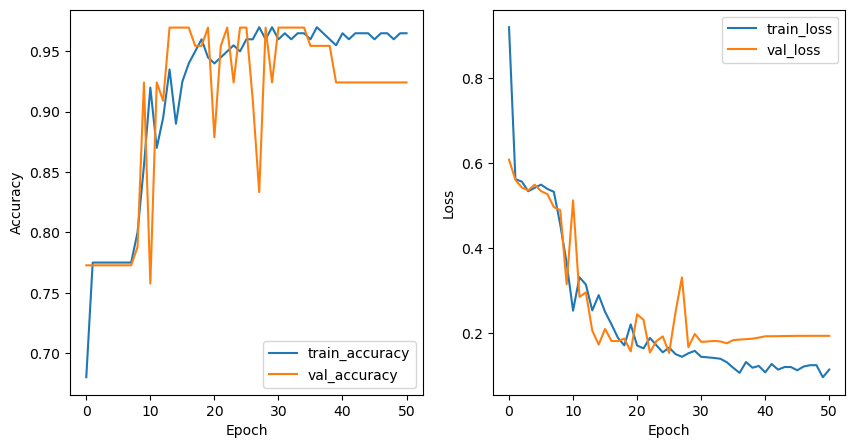

In [9]:
#simple_conv_model

simple_conv_model = Sequential([
    data_augmentation,

    Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the simple_conv_model
simple_conv_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
        
# Print the simple_conv_model summary
# simple_conv_model.summary()

# Train the simple_conv_model
epochs = 100
history = simple_conv_model.fit(
    train_data_scaled,
    validation_data=val_data_scaled,
    epochs=epochs,
    callbacks=callback_list,
)
# eval and plot simple conv model 
# Evaluate the simple_conv_model on the test data using `evaluate`
print("Evaluate on test data")
results = simple_conv_model.evaluate(test_data_scaled, batch_size=32)
print("test loss, test acc:", results)


# Plot the VGG16 model accuracy and loss curves using `matplotlib`
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [1]:
simple_conv_model.summary()

NameError: name 'simple_conv_model' is not defined

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.7750
Epoch 1: val_loss did not improve from 0.15351
13/13 [==============================] - 8s 292ms/step - loss: 0.5520 - accuracy: 0.7750 - val_loss: 0.5388 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7750
Epoch 2: val_loss did not improve from 0.15351
13/13 [==============================] - 1s 109ms/step - loss: 0.5503 - accuracy: 0.7750 - val_loss: 0.4908 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.7850
Epoch 3: val_loss did not improve from 0.15351
13/13 [==============================] - 1s 109ms/step - loss: 0.4965 - accuracy: 0.7850 - val_loss: 0.4640 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.7800
Epoch 4: val_loss did not improve from 0.15351


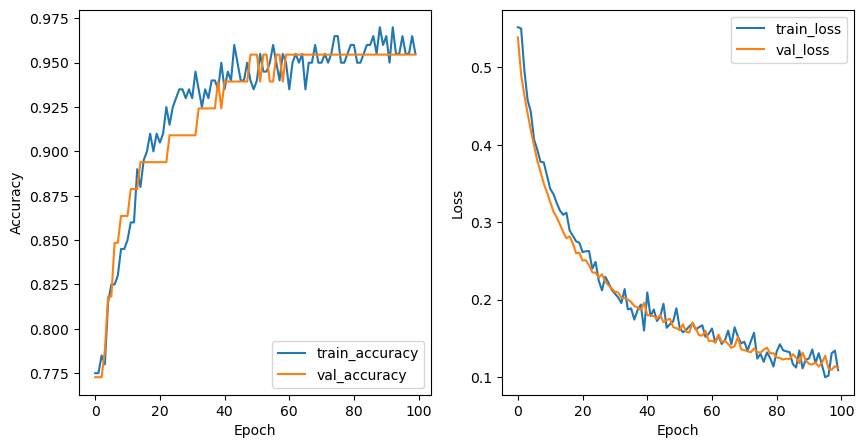

In [10]:
# keras vgg16 model
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D

# Load the VGG16 model without the top classification layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers in the VGG16 model
vgg16_base.trainable = False

# Create a sequential model
vgg16_model = Sequential([
    data_augmentation,
    vgg16_base,  # Add the VGG16 base model
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the VGG16 model
vgg16_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the VGG16 model
epochs = 100
history = vgg16_model.fit(
    train_data_scaled,
    validation_data=val_data_scaled,
    epochs=epochs,
    callbacks=callback_list
)
# plot the vgg16 model performance 
# Evaluate the VGG16 model on the test data using `evaluate`
print("Evaluate on test data")
results = vgg16_model.evaluate(test_data_scaled, batch_size=32)
print("test loss, test acc:", results)

# Plot the VGG16 model accuracy and loss curves using `matplotlib`
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.7500
Epoch 1: val_loss did not improve from 0.10906
13/13 [==============================] - 9s 328ms/step - loss: 0.5565 - accuracy: 0.7500 - val_loss: 0.4030 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3706 - accuracy: 0.8438
Epoch 2: val_loss did not improve from 0.10906
13/13 [==============================] - 1s 84ms/step - loss: 0.3688 - accuracy: 0.8450 - val_loss: 0.2765 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2502 - accuracy: 0.9219
Epoch 3: val_loss did not improve from 0.10906
13/13 [==============================] - 1s 83ms/step - loss: 0.2506 - accuracy: 0.9200 - val_loss: 0.2170 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2036 - accuracy: 0.9323
Epoch 4: val_loss did not improve from 0.10906
13

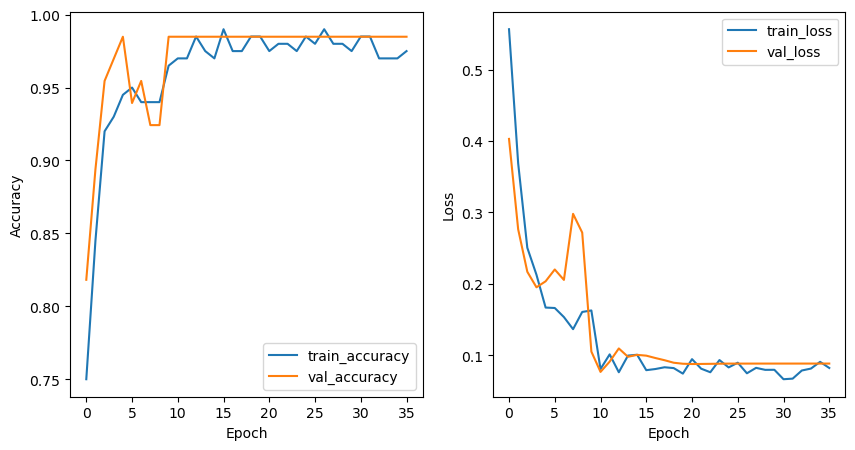

In [11]:
# keras Inception model

from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D

# Load the InceptionV3 model without the top classification layer
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers in the InceptionV3 model
inception_base.trainable = False

# Create a sequential model
inception_model = Sequential([
    data_augmentation,
    inception_base,  # Add the InceptionV3 base model
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the InceptionV3 model
inception_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the InceptionV3 model
epochs = 100
history = inception_model.fit(
    train_data_scaled,
    validation_data=val_data_scaled,
    epochs=epochs,
    callbacks=callback_list
)

# plot the inception model performance
# Evaluate the InceptionV3 model on the test data using `evaluate`
print("Evaluate on test data")
results = inception_model.evaluate(test_data_scaled, batch_size=32)
print("test loss, test acc:", results)

# Plot the InceptionV3 model accuracy and loss curves using `matplotlib` fixed 0 to 1 scale
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [12]:
tf.keras.backend.clear_session()

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.8100
Epoch 1: val_loss did not improve from 0.07689
13/13 [==============================] - 3s 115ms/step - loss: 0.4622 - accuracy: 0.8100 - val_loss: 0.2517 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9250
Epoch 2: val_loss did not improve from 0.07689
13/13 [==============================] - 1s 47ms/step - loss: 0.2263 - accuracy: 0.9250 - val_loss: 0.1611 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9450
Epoch 3: val_loss did not improve from 0.07689
13/13 [==============================] - 1s 47ms/step - loss: 0.1663 - accuracy: 0.9450 - val_loss: 0.1341 - val_accuracy: 0.9697 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9500
Epoch 4: val_loss did not improve from 0.07689
13

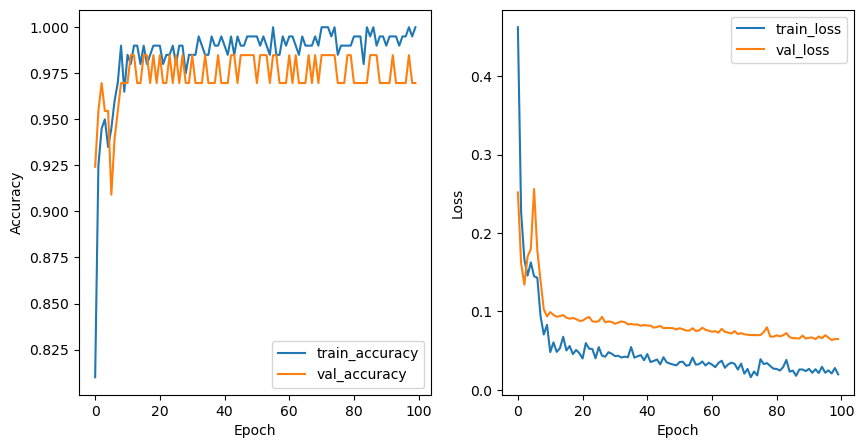

In [13]:
# keras mobilenet model
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D

# Load the MobileNet model without the top classification layer
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers in the MobileNet model
mobilenet_base.trainable = False

# Create a sequential model
mobilenet_model = Sequential([
    data_augmentation,
    mobilenet_base,  # Add the MobileNet base model
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the MobileNet model
mobilenet_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the MobileNet model
epochs = 100
history = mobilenet_model.fit(
    train_data_scaled,
    validation_data=val_data_scaled,
    epochs=epochs,
    callbacks=callback_list
)

# plot the mobilenet model performance
# Evaluate the MobileNet model on the test data using `evaluate`
print("Evaluate on test data")
results = mobilenet_model.evaluate(test_data_scaled, batch_size=32)
print("test loss, test acc:", results)

# Plot the MobileNet model accuracy and loss curves using `matplotlib` fixed 0 to 1 scale
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
